In [61]:
import ipynbname
# Get the full path of the notebook file
notebook_file = ipynbname.path()
notebook_folder = notebook_file.parent
import os
os.chdir(notebook_folder)
print(os.getcwd())
data_path = os.path.join("..", "Data", "drug200.csv")

/Users/yufu/Desktop/CICD-ML-Pipeline/Results


In [62]:
drug_df = pd.read_csv(data_path)
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
101,45,F,HIGH,HIGH,12.854,drugA
68,54,M,NORMAL,HIGH,24.658,DrugY
125,19,F,HIGH,NORMAL,25.969,DrugY


In [63]:
from sklearn.model_selection import train_test_split

X = drug_df.drop("Drug", axis=1).values
y = drug_df.Drug.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = [1,2,3]
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col),
    ]
)
pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=125)),
    ]
)
pipe.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('num_imputer', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

Accuracy: 97.0% F1: 0.88


In [66]:
with open("metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}.")

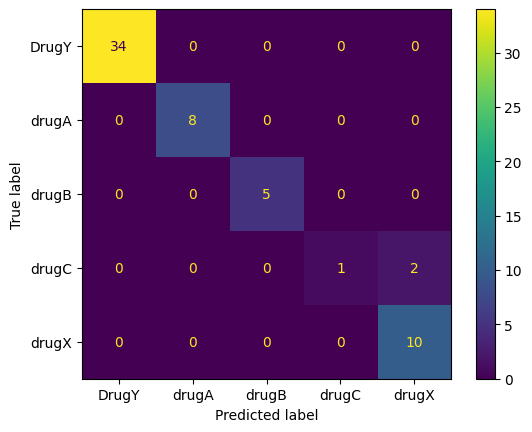

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("model_results.png", dpi=120)

In [68]:
from skops.io import dump, load, get_untrusted_types
data_path = os.path.join("..", "Model", "pipeline.skops")
dump(pipe, data_path)

In [69]:
unknown_types = get_untrusted_types(file=os.path.join("..", "Model", "pipeline.skops"))
loaded = load(data_path, trusted=unknown_types)